In [497]:
import os
import glob
import pandas as pd
import numpy as np
from collections import defaultdict
import copy
import subprocess
import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

# Set the working directory to the notebook location
notebook_dir = os.getcwd()  # Get current working directory of the notebook

# Ensure custom module paths are included
tracking_diagnostics_path = os.path.abspath(os.path.join(notebook_dir, 'tracking-diagnostics'))

sys.path.append(tracking_diagnostics_path)

print("Tracking diagnostics path:", tracking_diagnostics_path)

from diagnostics.video import get_frames_from_idxs
from eks.utils import convert_lp_dlc, format_data
from pseudo_labeler.utils import format_data_walk
from pseudo_labeler.evaluation import compute_likelihoods_and_variance, plot_heatmaps

Tracking diagnostics path: /teamspace/studios/this_studio/tracking-diagnostics


In [498]:
# ADJUST THESE
dir = '/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000'
videos_dir = '/teamspace/studios/this_studio/data/mirror-mouse'  # video to be overlayed on
n_frames = 10
top_error_frame_count = 3
excluded_keypoints = ['obs_top', 'obsHigh_bot', 'obsLow_bot']
file_names = ["test_vid", "test_vid_new"]  # the specific video files you want plotted 
# END ADJUST

file_name = file_names[0]  # Default file name, can be changed later

# Define paths relative to the base directory -- these shouldn't change unless using a different baseline
networks_dir = os.path.join(dir, 'networks')
eks_dir = os.path.join(dir, 'post-processors', 'eks_rng=0-3')  # specify this directory
aeks_dir = os.path.join(dir, 'results_amortized_eks')
output_dir = os.path.join(dir, 'eks_aeks_pixel_diff')

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

# Print paths to verify
print(f"Base Directory: {dir}")
print(f"Videos Directory: {videos_dir}")
print(f"Number of Frames: {n_frames}")
print(f"Excluded Keypoints: {excluded_keypoints}")
print(f"Networks Directory: {networks_dir}")
print(f"EKS Directory: {eks_dir}")
print(f"AEKS Directory: {aeks_dir}")
print(f"Output Directory: {output_dir}")
print(f"Relative Pixel Error Directory: {relative_pixel_error_dir}")

Base Directory: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000
Videos Directory: /teamspace/studios/this_studio/data/mirror-mouse
Number of Frames: 10
Excluded Keypoints: ['obs_top', 'obsHigh_bot', 'obsLow_bot']
Networks Directory: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks
EKS Directory: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3
AEKS Directory: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks
Output Directory: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff
Relative Pixel Error Directory: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/relative_pixel_error


In [499]:
# Helper Functions
def get_subdirectories(directory):
    return [os.path.join(directory, sub_dir) for sub_dir in os.listdir(directory) if os.path.isdir(os.path.join(directory, sub_dir))]

def get_csv_files(directory, file_name):
    pattern = os.path.join(directory, f'**/*{file_name}.csv')
    return glob.glob(pattern, recursive=True)

def group_csv_files(eks_files, aeks_files):
    file_groups = defaultdict(list)
    
    for file in eks_files:
        file_name = os.path.basename(file)
        file_groups[file_name].append(file)
        
    for file in aeks_files:
        file_name = os.path.basename(file)
        file_groups[file_name].append(file)
        
    return file_groups

def calculate_pixel_error(file1, file2, top_frame_count=20):
    df1 = pd.read_csv(file1, header=[0, 1, 2])
    df2 = pd.read_csv(file2, header=[0, 1, 2])
    
    scorer1 = df1.columns.levels[0][0]  # Automatically detect the first-level column header for df1
    scorer2 = df2.columns.levels[0][0]  # Automatically detect the first-level column header for df2
    
    keypoints = df1.columns.get_level_values(1).unique()
    errors = defaultdict(list)
    top_error_frames = []
    
    for keypoint in keypoints:
        if keypoint == 'bodyparts':
            continue
        
        x1 = df1[scorer1, keypoint, 'x']
        y1 = df1[scorer1, keypoint, 'y']
        x2 = df2[scorer2, keypoint, 'x']
        y2 = df2[scorer2, keypoint, 'y']
        
        distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        errors[keypoint] = distance
        
        top_indices = distance.nlargest(top_frame_count).index
        top_error_frames.extend([(keypoint, idx, distance[idx]) for idx in top_indices])
    
    error_df = pd.DataFrame(errors)
    top_error_df = pd.DataFrame(top_error_frames, columns=['keypoint', 'frame', 'error'])
    return error_df, top_error_df

def save_video(save_file, tmp_dir, framerate, frame_pattern='frame_%06d.jpeg'):
    call_str = f'ffmpeg -r {framerate} -loglevel error -y -i {os.path.join(tmp_dir, frame_pattern)} -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" {save_file}'
    if os.name == 'nt':  # If the OS is Windows
        subprocess.run(['ffmpeg', '-loglevel', 'error', '-r', str(framerate), '-y', '-i', f'{tmp_dir}/frame_%06d.jpeg',
                        '-c:v', 'libx264', '-vf', "pad=ceil(iw/2)*2:ceil(ih/2)*2",
                        save_file],
                       check=True)
    else:  # If the OS is Unix/Linux
        subprocess.run(['/bin/bash', '-c', call_str], check=True)

def plot_video_markers(markers_pd, ax, n, body_part, color, alphas, markers, model_id=0, markersize=8):
    x_key = body_part + '_x'
    y_key = body_part + '_y'
    markers_x = markers_pd[x_key][n]
    markers_y = markers_pd[y_key][n]
    ax.scatter(markers_x, markers_y, alpha=alphas[model_id], marker="o", color=color)

def read_error_files(relative_pixel_error_dir, file_name):
    error_data = {}

    for subdir, dirs, files in os.walk(relative_pixel_error_dir):
        for file in files:
            if not file.endswith('.csv'):
                continue
            if file_name not in file:
                continue
            try:
                model_name = os.path.splitext(file)[0].replace('error_', '')
                error_df = pd.read_csv(os.path.join(subdir, file))
                error_data[model_name] = error_df
            except Exception as e:
                print(f"Error reading file {file}: {e}")

    print(f"Read {len(error_data)} pixel error files into DataFrame.")
    return error_data


def expanding_mean(arr):
    return np.cumsum(arr) / np.arange(1, len(arr) + 1)

def organize_error_files(relative_pixel_error_dir):
    error_files = [f for f in os.listdir(relative_pixel_error_dir) if f.endswith('.csv')]
    for file in error_files:
        file_base_name = file.split('_')[1]
        sub_dir = os.path.join(relative_pixel_error_dir, file_base_name)
        if not os.path.exists(sub_dir):
            os.makedirs(sub_dir)
        os.rename(os.path.join(relative_pixel_error_dir, file), os.path.join(sub_dir, file))

def find_matching_video(videos_dir, base_file_name):
    for root, _, files in os.walk(videos_dir):
        for file in files:
            if file.startswith(base_file_name) and file.endswith(('.mp4', '.avi', '.mov')):
                return os.path.join(root, file)
    return None

In [500]:
def create_summed_ensemble_variance(networks_dir, output_dir, file_name):
    data_type = 'lp'
    input_dfs, output_df, _ = format_data_walk(networks_dir, data_type, f'{file_name}.csv')
    print(f'Found {len(input_dfs)} models.')
    likelihood_thresh = 0.9
    likelihoods_above_thresh, summed_ensemble_vars, combined_df, bodypart_list = compute_likelihoods_and_variance(input_dfs, likelihood_thresh)

    # Create a DataFrame from summed_ensemble_vars
    summed_ensemble_vars_df = pd.DataFrame(summed_ensemble_vars, columns=bodypart_list)

    # Define the output file path
    output_file_path = os.path.join(output_dir, f"summed_ensemble_vars_{file_name}.csv")

    # Save the DataFrame to a CSV file
    summed_ensemble_vars_df.to_csv(output_file_path, index=False)

    print(f'Saved summed_ensemble_vars to {output_file_path}')
    return output_file_path

In [501]:
def calculate_errors_main(eks_dir, aeks_dir, output_dir, file_name, top_error_frame_count=20):
    eks_csv_files = get_csv_files(eks_dir, file_name)
    if not eks_csv_files:
        print(f"No matching EKS files found for {file_name} in {eks_dir}")
        return {}, []

    all_top_error_frames = {}
    all_error_dfs = []

    aeks_subdirs = [os.path.join(aeks_dir, sub_dir) for sub_dir in os.listdir(aeks_dir) if os.path.isdir(os.path.join(aeks_dir, sub_dir))]
    if not aeks_subdirs:
        print(f"No AEKS subdirectories found in {aeks_dir}")
        return {}, []

    for eks_file in eks_csv_files:
        eks_file_name = os.path.basename(eks_file)
        
        for sub_dir in aeks_subdirs:
            aeks_csv_files = get_csv_files(sub_dir, file_name)
            if not aeks_csv_files:
                print(f"No matching AEKS files found for {file_name} in {sub_dir}")
                continue

            for aeks_file in aeks_csv_files:
                aeks_file_name = os.path.basename(aeks_file)

                if eks_file_name in aeks_file_name:
                    try:
                        error_df, top_error_df = calculate_pixel_error(eks_file, aeks_file, top_error_frame_count)
                    except Exception as e:
                        print(f"Error calculating pixel error between {eks_file_name} and {aeks_file_name}: {e}")
                        continue

                    base_file_name = os.path.splitext(eks_file_name)[0]  # Remove the original .csv extension if present
                    sub_dir_name = os.path.basename(sub_dir) if 'eks' not in os.path.basename(sub_dir) else 'aeks_eks'

                    # Save the error CSV to the relative_pixel_error directory
                    relative_pixel_error_dir = os.path.join(output_dir, 'relative_pixel_error')
                    if not os.path.exists(relative_pixel_error_dir):
                        os.makedirs(relative_pixel_error_dir)
                    error_output_file = os.path.join(relative_pixel_error_dir, f"error_{base_file_name}_{sub_dir_name}.csv")
                    error_df.to_csv(error_output_file, index=False)

                    # Save top error frames CSV
                    top_error_frames_dir = os.path.join(output_dir, 'top_error_frames')
                    if not os.path.exists(top_error_frames_dir):
                        os.makedirs(top_error_frames_dir)
                    top_error_frames_file = os.path.join(top_error_frames_dir, f"top_error_frames_{base_file_name}_{sub_dir_name}.csv")
                    top_error_df.to_csv(top_error_frames_file, index=False)

                    all_top_error_frames[f"{base_file_name}_{sub_dir_name}"] = top_error_df
                    all_error_dfs.append((error_df, sub_dir_name))

    return all_top_error_frames, all_error_dfs

In [502]:
def plot_video_frames(eks_dir, aeks_dir, output_dir, video_path, n_frames, file_name):
    eks_file = get_csv_files(eks_dir, file_name)[0]
    aeks_subdirs = get_subdirectories(aeks_dir)

    # Create a parent directory for the output videos for this eks_file
    parent_output_dir = os.path.join(output_dir, f'{base_file_name}_plotted_vids')
    if not os.path.exists(parent_output_dir):
        os.makedirs(parent_output_dir)

    for sub_dir in aeks_subdirs:
        aeks_csv_files = get_csv_files(sub_dir, file_name)
        matching_aeks_files = [f for f in aeks_csv_files if f'{file_name}.csv' in os.path.basename(f)]

        if not matching_aeks_files:
            print(f"No matching aEKS file found for {file_name} in {sub_dir}")
            continue

        aeks_file = matching_aeks_files[0]

        # Create a directory for the output videos inside the parent directory
        output_subdir = os.path.join(parent_output_dir, os.path.basename(sub_dir))
        if not os.path.exists(output_subdir):
            os.makedirs(output_subdir)

        # Load EKS
        print(eks_file)
        markers_curr = pd.read_csv(eks_file, header=[0, 1, 2], index_col=0)
        keypoint_names = [c[1] for c in markers_curr.columns[::3]]
        model_name = markers_curr.columns[0][0]
        eks_pd = convert_lp_dlc(markers_curr, keypoint_names, model_name)

        # Load AEKS
        markers_curr = pd.read_csv(aeks_file, header=[0, 1, 2], index_col=0)
        keypoint_names = [c[1] for c in markers_curr.columns[::3]]
        model_name = markers_curr.columns[0][0]
        eks_pd2 = convert_lp_dlc(markers_curr, keypoint_names, model_name)

        # Setup for plotting
        animal_ids = [1]
        body_parts = ['tailMid_bot']  # Add other body parts as needed
        to_plot = []
        for animal_id in animal_ids:
            for body_part in body_parts:
                to_plot.append(body_part)

        cap = cv2.VideoCapture(video_path)

        start_frame = 1
        idxs = np.arange(start_frame, start_frame + n_frames)
        framerate = 20

        colors = ['cyan', 'pink']
        alphas = [.8, 1.0]
        markers = ['.', 'x']
        model_labels = ['AEKS', 'EKS']
        model_colors = colors

        for body_part in to_plot:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            tmp_dir = os.path.join(output_subdir, f'tmp_{body_part}')
            if not os.path.exists(tmp_dir):
                os.makedirs(tmp_dir)
            save_file = os.path.join(output_subdir, f'{base_file_name}_{body_part}.mp4')

            txt_fr_kwargs = {
                'fontsize': 14, 'color': [1, 1, 1], 'horizontalalignment': 'left',
                'verticalalignment': 'top', 'fontname': 'monospace',
                'bbox': dict(facecolor='k', alpha=0.25, edgecolor='none'),
                'transform': ax.transAxes
            }
            save_imgs = True
            markersize = 18 if save_imgs else 12
            for idx in tqdm(range(len(idxs))):
                n = idxs[idx]
                ax.clear()
                frame = get_frames_from_idxs(cap, [n])
                ax.imshow(frame[0, 0], vmin=0, vmax=255, cmap='gray')
                ax.set_xticks([])
                ax.set_yticks([])
                patches = []

                # AEKS
                plot_video_markers(eks_pd2, ax, n, body_part, colors[0], alphas, markers, model_id=0, markersize=markersize)
                # EKS
                plot_video_markers(eks_pd, ax, n, body_part, colors[1], alphas, markers, model_id=1, markersize=markersize)

                # Legend
                for i, model_label in enumerate(model_labels):
                    patches.append(mpatches.Patch(color=model_colors[i], label=model_label))
                ax.legend(handles=patches, prop={'size': 12}, loc='upper right')
                im = ax.text(0.02, 0.98, f'frame {n}', **txt_fr_kwargs)
                plt.savefig(os.path.join(tmp_dir, 'frame_%06d.jpeg' % idx))
            save_video(save_file, tmp_dir, framerate, frame_pattern='frame_%06d.jpeg')
            # Clean up temporary directory
            for file in os.listdir(tmp_dir):
                os.remove(os.path.join(tmp_dir, file))
            os.rmdir(tmp_dir)

In [503]:
def plot_top_error_frames(video_path, eks_dir, aeks_dir, output_dir, top_error_frames):
    cap = cv2.VideoCapture(video_path)
    
    for key in top_error_frames:
        base_file_name, sub_dir = key.split('_', 1)
        top_error_df = top_error_frames[key]
        subdirectory_name = f"{base_file_name}_{sub_dir}"
        
        top_error_frames_subdir = os.path.join(output_dir, 'top_error_frames', subdirectory_name)
        if not os.path.exists(top_error_frames_subdir):
            os.makedirs(top_error_frames_subdir)
        
        for _, row in top_error_df.iterrows():
            keypoint = row['keypoint']
            frame_idx = row['frame']
            error = row['error']
            
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if not ret:
                print(f"Failed to read frame {frame_idx}")
                continue
            
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(frame, vmin=0, vmax=255)
            ax.set_title(f"Frame {frame_idx} - {keypoint} - Error: {error:.2f}")
            ax.axis('off')

            output_file = os.path.join(top_error_frames_subdir, f"frame_{frame_idx}_{keypoint}.png")
            plt.savefig(output_file, bbox_inches='tight')
            plt.close()
            print(f"Saved overlay frame plot to {output_file}")
    
    cap.release()

In [504]:
def plot_pixel_error_vs_ensemble_variance_from_files(error_data, ensemble_variance_csv, output_dir, file_name, excluded_keypoints=None):
    ensemble_variance_df = pd.read_csv(ensemble_variance_csv)
    
    if excluded_keypoints is None:
        excluded_keypoints = []

    def plot_filtered_error_data(filtered_error_data, title_suffix):
        plt.figure(figsize=(10, 6))
        
        aeks_eks_plotted = False
        aeks_plotted = False

        for model_name, error_df in filtered_error_data.items():
            combined_errors = []
            combined_variance = []
            keypoints = error_df.columns

            for keypoint in keypoints:
                if keypoint in excluded_keypoints:
                    continue

                errors = error_df[keypoint].dropna()
                ensemble_variance = ensemble_variance_df[keypoint].dropna()

                if len(errors) == 0 or len(ensemble_variance) == 0:
                    continue

                combined_errors.extend(errors)
                combined_variance.extend(ensemble_variance)

            if len(combined_errors) == 0 or len(combined_variance) == 0:
                continue

            combined_errors = np.array(combined_errors)
            combined_variance = np.array(combined_variance)

            sorted_indices = np.argsort(combined_variance)
            sorted_combined_variance = combined_variance[sorted_indices]
            sorted_combined_errors = combined_errors[sorted_indices]
            avg_sorted_combined_errors = expanding_mean(sorted_combined_errors)

            # Define colors and labels
            if 'aeks_eks' in model_name:
                color = 'cyan'
                label = f'{title_suffix}_aeks_eks' if not aeks_eks_plotted else None
                aeks_eks_plotted = True
            else:
                color = 'gray'
                label = f'{title_suffix}_aeks' if not aeks_plotted else None
                aeks_plotted = True

            plt.plot(sorted_combined_variance, avg_sorted_combined_errors, label=label, color=color)

        plt.xlabel('Cumulative Ensemble Variance')
        plt.ylabel('Average Pixel Error')
        plt.title(f'EKS-relative Pixel Error vs Ensemble Variance for {title_suffix}')
        plt.grid(True)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        combined_plot_output_file = os.path.join(output_dir, f'pixel_error_vs_ensemble_variance_{title_suffix}.png')
        plt.savefig(combined_plot_output_file, bbox_inches='tight')
        plt.close()
        print(f'Saved combined plot for all keypoints to {combined_plot_output_file}')

    plot_filtered_error_data(error_data, file_name)

Processing test_vid...


Found 4 models.
Saved summed_ensemble_vars to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/summed_ensemble_vars_test_vid.csv
Summed ensemble variance CSV created at: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/summed_ensemble_vars_test_vid.csv
Read 5 pixel error files into DataFrame.
Saved combined plot for all keypoints to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/pixel_error_vs_ensemble_variance_test_vid.png
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid.csv


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid.csv


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid.csv


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid.csv


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid.csv


100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/top_error_frames/test_vid_aeks_eks/frame_18_paw1LH_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/top_error_frames/test_vid_aeks_eks/frame_48_paw1LH_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/top_error_frames/test_vid_aeks_eks/frame_16_paw1LH_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/top_error_frames/test_vid_aeks_eks/frame_818_paw2LF_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid/top_error_frames/test_vid_aeks_eks/frame_819_paw2LF_top.png
Saved overlay frame plot to /teamspace/studios/this_s

100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid_new.csv


100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid_new.csv


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid_new.csv


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/test_vid_new.csv


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid_new/top_error_frames/test_vid_new_aeks_eks/frame_18_paw1LH_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid_new/top_error_frames/test_vid_new_aeks_eks/frame_48_paw1LH_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid_new/top_error_frames/test_vid_new_aeks_eks/frame_16_paw1LH_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid_new/top_error_frames/test_vid_new_aeks_eks/frame_818_paw2LF_top.png
Saved overlay frame plot to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/eks_aeks_pixel_diff/test_vid_new/top_error_frames/test_vid_new_aeks_eks/frame_819_paw2LF_top.png
Saved overlay

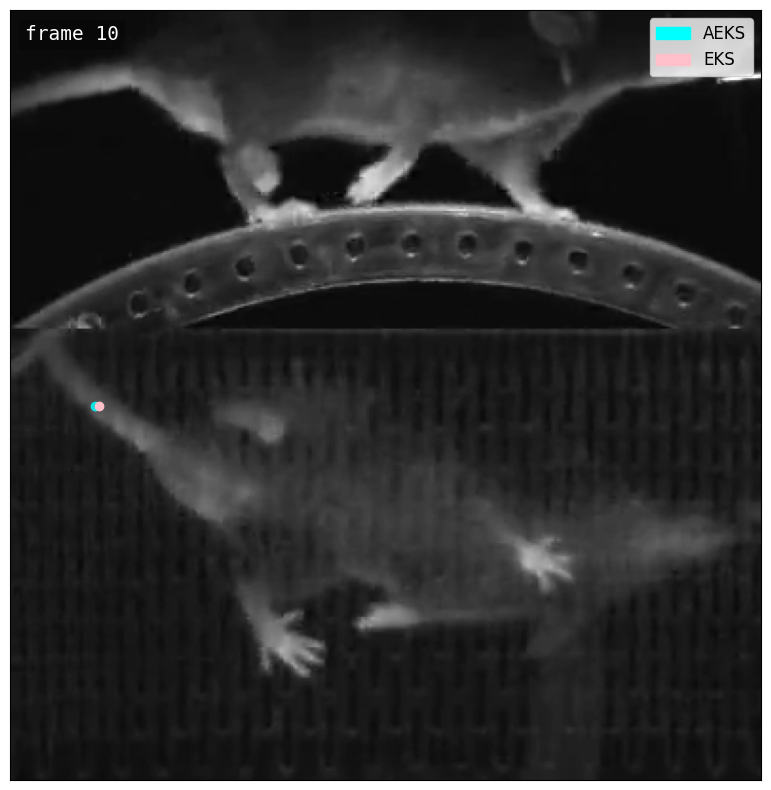

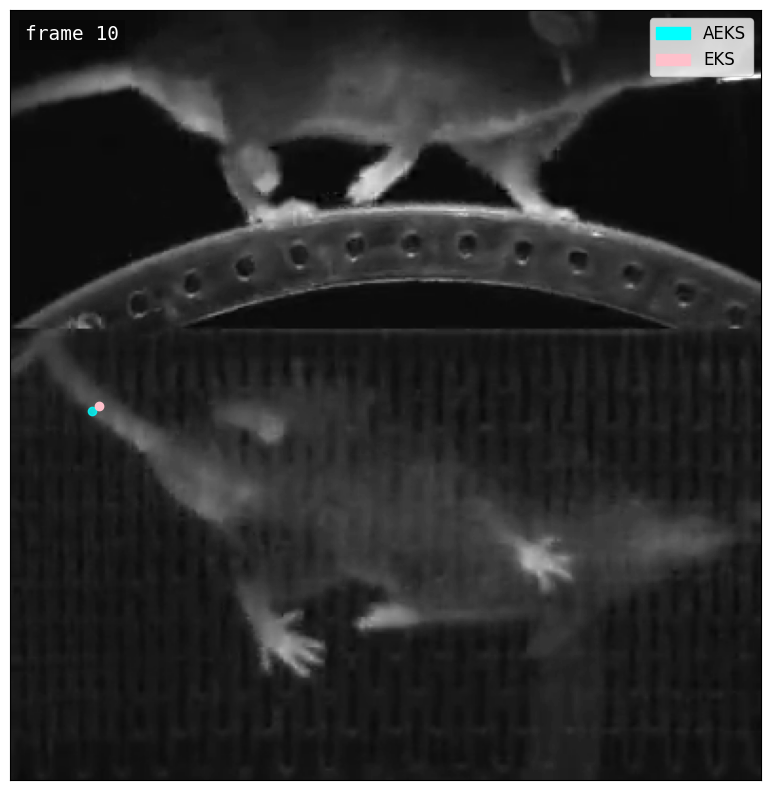

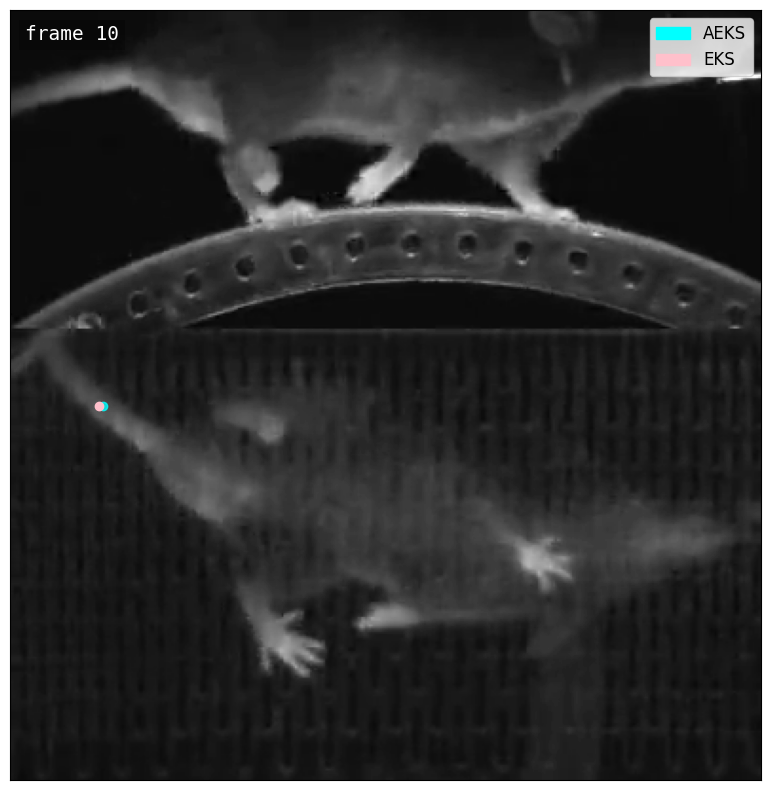

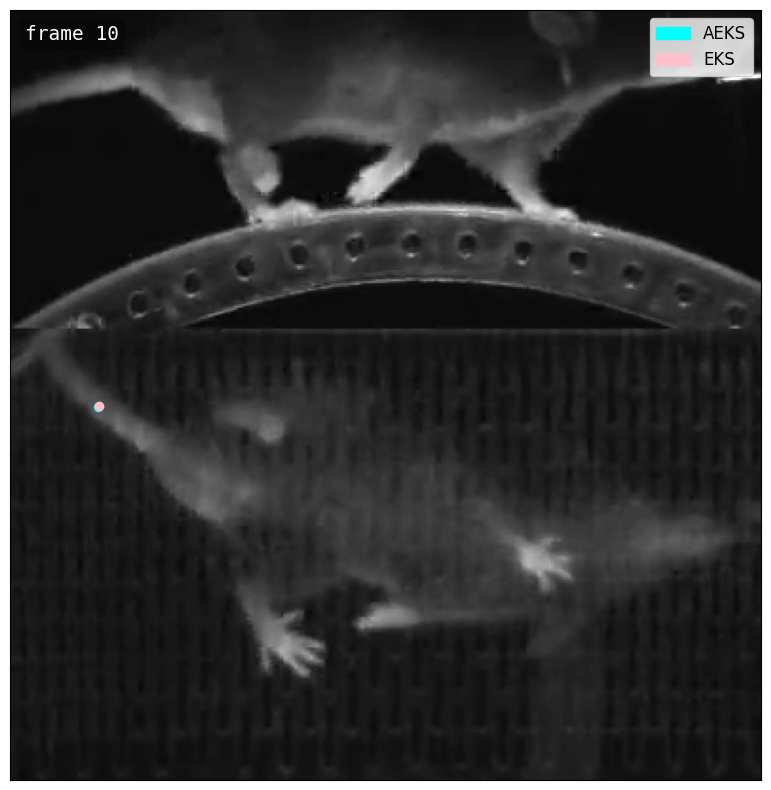

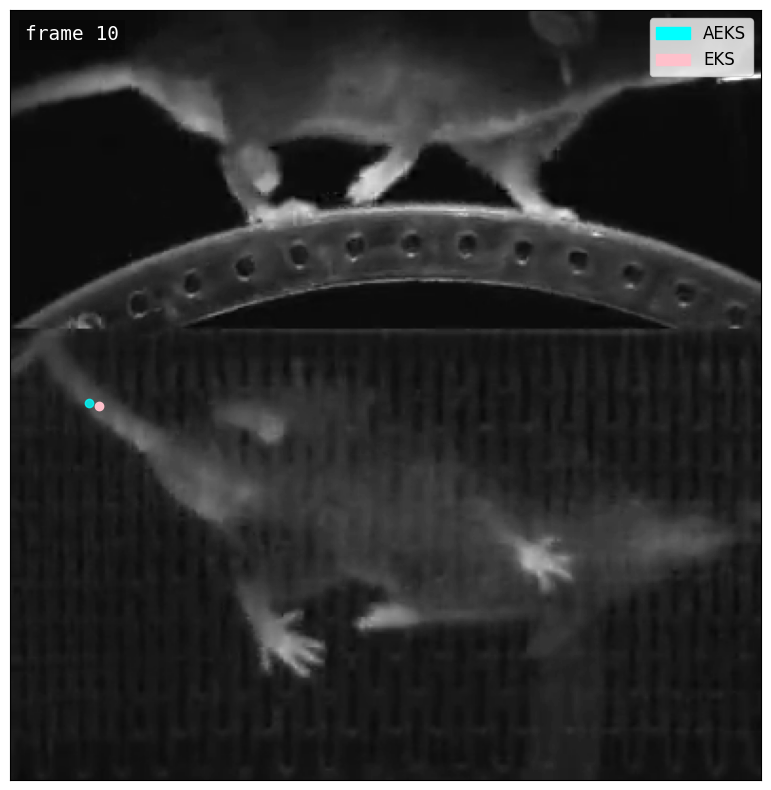

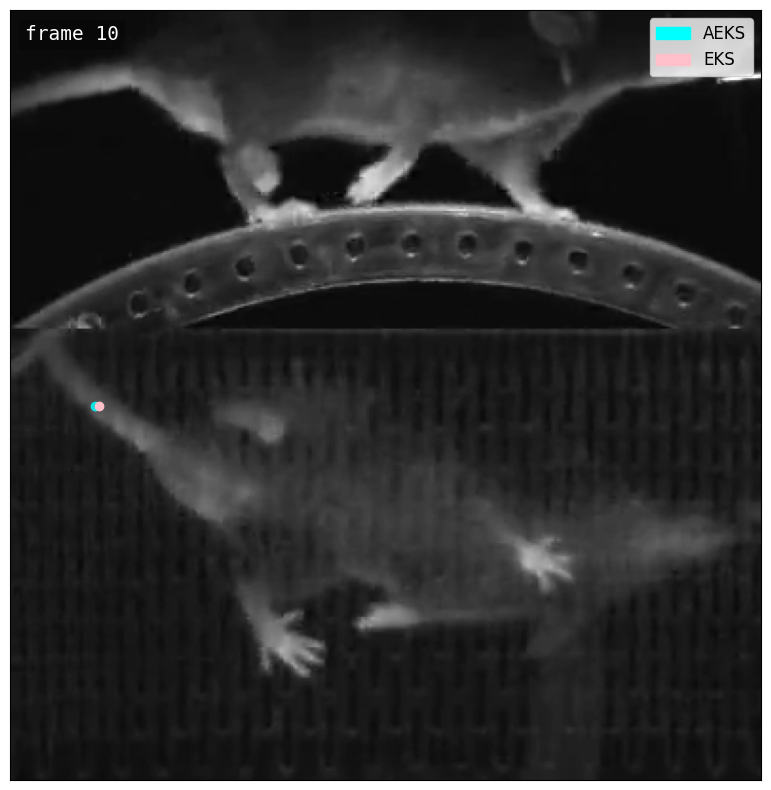

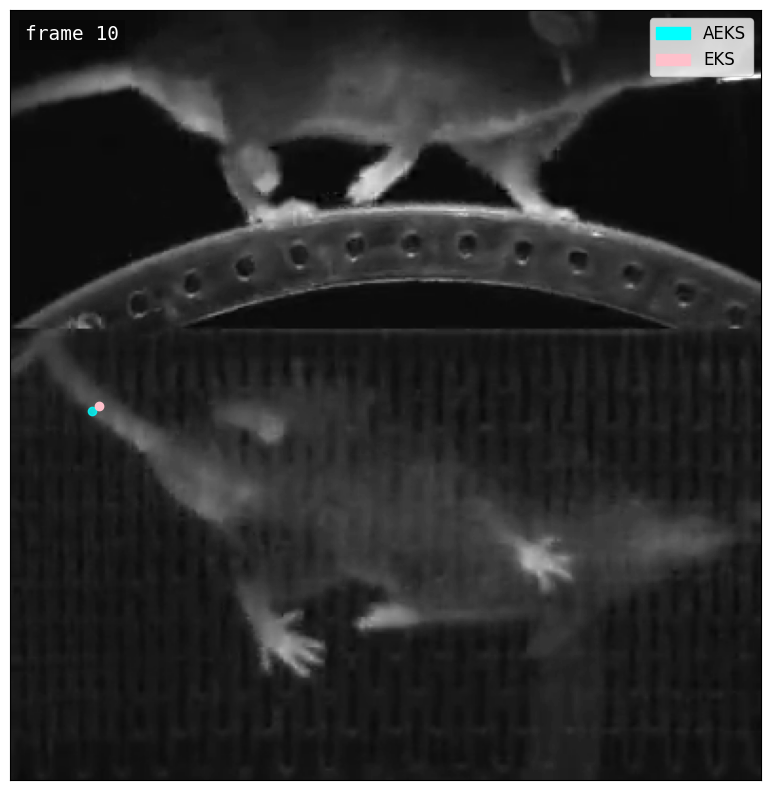

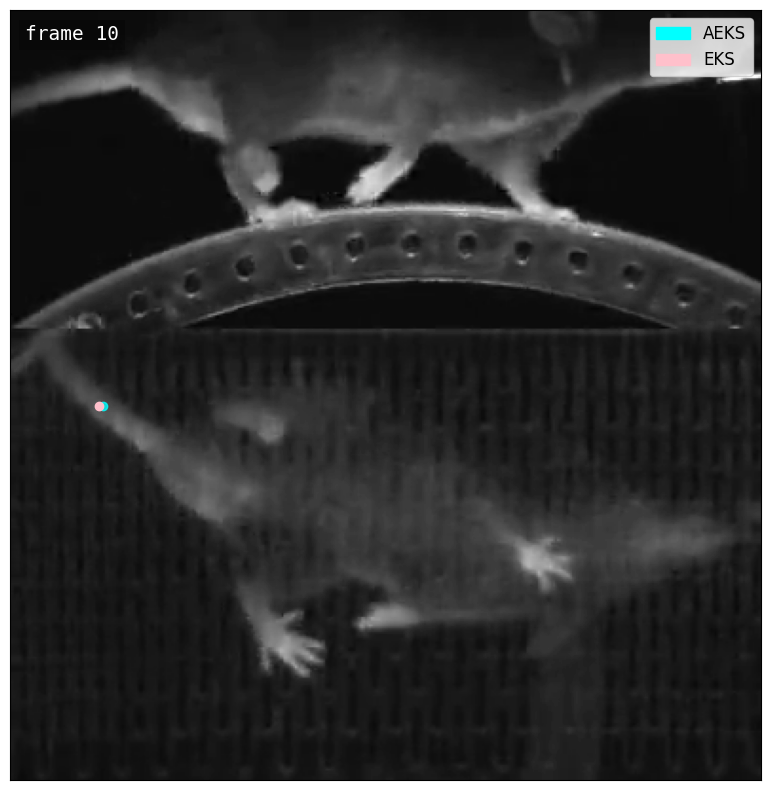

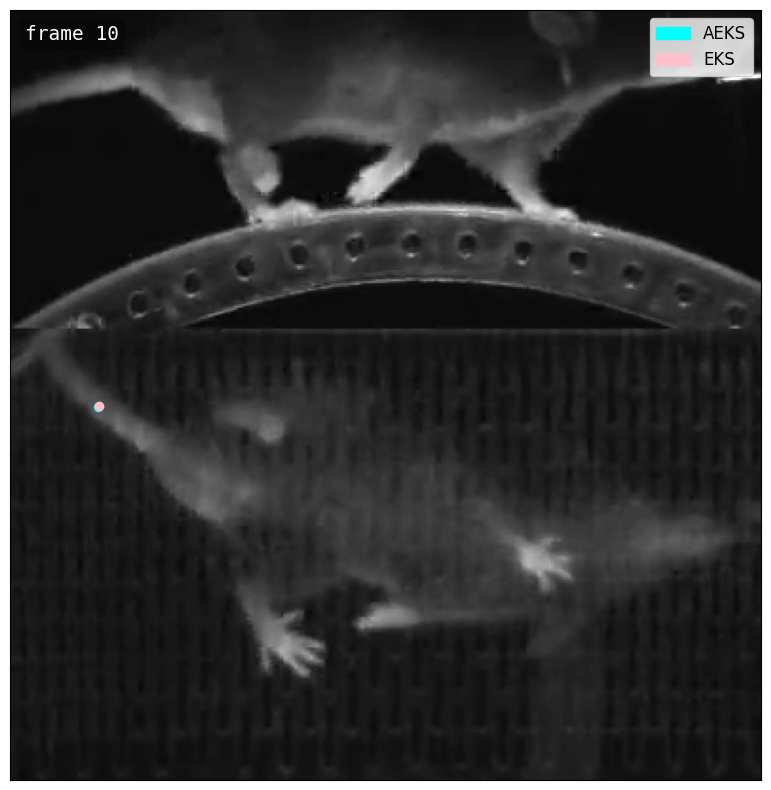

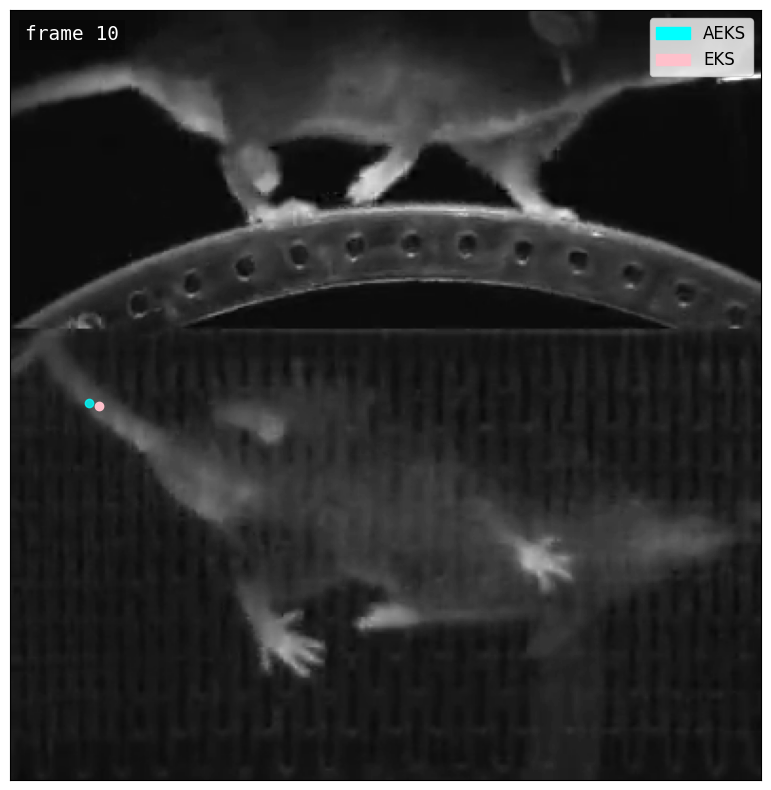

In [505]:
for file_name in file_names:
    print(f"Processing {file_name}...")

    # Create the base output directory with the specified name
    base_output_dir = os.path.join(output_dir, f'{file_name}')
    top_error_frames_dir = os.path.join(base_output_dir, 'top_error_frames')
    relative_pixel_error_dir = os.path.join(base_output_dir, 'relative_pixel_error')

    # Ensure the directories exist
    if not os.path.exists(top_error_frames_dir):
        os.makedirs(top_error_frames_dir)
    if not os.path.exists(relative_pixel_error_dir):
        os.makedirs(relative_pixel_error_dir)

    # Find path to video
    base_file_name = os.path.splitext(file_name)[0]  # Remove file extension
    video_path = find_matching_video(videos_dir, base_file_name)
    if not video_path:
        print(f"No matching video found for {file_name}")
        continue
    
    # Create the summed ensemble variance CSV
    summed_ensemble_variance_csv_path = create_summed_ensemble_variance(networks_dir, base_output_dir, file_name)
    print(f'Summed ensemble variance CSV created at: {summed_ensemble_variance_csv_path}')
    
    # Generate error files (Ensure these functions are defined and working correctly)
    top_error_frames, all_error_dfs = calculate_errors_main(eks_dir, aeks_dir, base_output_dir, file_name, top_error_frame_count)
    
    # Read the error files
    error_data = read_error_files(relative_pixel_error_dir, file_name)
    
    # Plot pixel error vs ensemble variance using the created CSV
    plot_pixel_error_vs_ensemble_variance_from_files(error_data, summed_ensemble_variance_csv_path, base_output_dir, file_name, excluded_keypoints)
    
    # Plot video frames with high pixel error
    plot_video_frames(eks_dir, aeks_dir, base_output_dir, video_path, n_frames, file_name)

    # Plot top error frames
    plot_top_error_frames(video_path, eks_dir, aeks_dir, base_output_dir, top_error_frames)